<a href="https://colab.research.google.com/github/Ryzinqx/Logistic_Regression_Algorithm-_Lung-Cancer/blob/main/Implementation_of_Logistic_Regression_Algorithm_For_Lung_Cancer_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install pyspark

In [117]:
# menimport library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [72]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Semester V/Big Data and Data Mining/Week 15 - UAS/survey lung cancer.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# load data
df = pd.read_csv(file_path)
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

(None,
   GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
 0      M   69        1               2        2              1   
 1      M   74        2               1        1              1   
 2      F   59        1               1        1              2   
 3      M   63        2               2        2              1   
 4      F   63        1               2        1              1   
 
    CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
 0                1         2         1         2                  2         2   
 1                2         2         2         1                  1         1   
 2                1         2         1         2                  1         2   
 3                1         1         1         1                  2         1   
 4                1         1         1         2                  1         2   
 
    SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN LUNG_CANCER  
 0                    

In [74]:
# data cleaning (mengganti nama kolom)
for old_name, new_name in {
    'GENDER': 'jenis_kelamin',
    'AGE': 'umur',
    'SMOKING': 'merokok',
    'YELLOW_FINGERS': 'jari_kuning',
    'ANXIETY': 'kecemasan',
    'PEER_PRESSURE': 'tekanan_dari_teman',
    'CHRONIC DISEASE': 'penyakit_kronis',
    'FATIGUE ': 'kelelahan',
    'ALLERGY ': 'alergi',
    'WHEEZING': 'mengi',
    'ALCOHOL CONSUMING': 'konsumsi_alkohol',
    'COUGHING': 'batuk',
    'SHORTNESS OF BREATH': 'sesak_napas',
    'SWALLOWING DIFFICULTY': 'kesulitan_menelan',
    'CHEST PAIN': 'sakit_dada',
    'LUNG_CANCER': 'kanker_paru'
  }.items():
  df = df.rename(columns={old_name: new_name})

In [75]:
# cek duplikat
df.duplicated().sum()
print("kolom duplikat:", duplicate_count)

kolom duplikat: 33


In [76]:
# hapus duplikat
df = df.drop_duplicates()

In [77]:
# mengecek apakah masih ada duplikat
sisa_duplikat = df.duplicated().sum()

# Print the result
print("Sisa Duplikat:", sisa_duplikat)

Sisa Duplikat: 0


In [79]:
# data transformasi
# mendefinisikan kolom kategorikal
categorical = ('jenis_kelamin', 'kanker_paru')

In [80]:
# normalisasi menggunakan data umur
scaler = MinMaxScaler()
# Access the column using the new name 'umur' instead of the old name "AGE"
df['umur_normalisasi'] = scaler.fit_transform(df[['umur']])

In [89]:
# menyortir dari umur dari muda ke tua
df_sortir = df.sort_values(by='umur_normalisasi')
print(df_sortir)

     jenis_kelamin  umur  merokok  jari_kuning  kecemasan  tekanan_dari_teman  \
22               0    21        2            1          1                   1   
238              0    38        1            2          1                   1   
261              1    39        2            1          1                   2   
168              1    44        1            2          1                   2   
20               0    44        2            2          2                   2   
..             ...   ...      ...          ...        ...                 ...   
230              1    78        1            2          1                   2   
204              1    79        2            1          1                   1   
83               0    81        1            1          1                   2   
101              0    81        1            2          2                   2   
277              0    87        1            1          1                   1   

     penyakit_kronis  kelel

In [90]:
# mengubah data kategorikal
le = LabelEncoder()
for col in ['jenis_kelamin', 'kanker_paru']:
  df[col] = le.fit_transform(df[col])

In [91]:
df

,jenis_kelamin,umur,merokok,jari_kuning,kecemasan,tekanan_dari_teman,penyakit_kronis,kelelahan,alergi,mengi,konsumsi_alkohol,batuk,sesak_napas,kesulitan_menelan,sakit_dada,kanker_paru,umur_normalisasi
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1,0.727273
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1,0.803030
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0,0.575758
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0,0.636364
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0,0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0,59,1,2,2,2,1,1,2,2,1,2,1,2,1,1,0.575758
280,0,59,2,1,1,1,2,2,2,1,1,1,2,1,1,0,0.575758
281,1,55,2,1,1,1,1,2,2,1,1,1,2,1,2,0,0.515152
282,1,46,1,2,2,1,1,1,1,1,1,1,1,2,2,0,0.378788


- 87,38%: memiliki label YES
- 12,62%: memiliki label NO
- dataset: imbalance dikarenakan YES lebih sering

# EDA

In [100]:
# melihat ukuran dataset
num_rows, num_cols = df.shape

print(f"Jumlah baris: {num_rows}")
print(f"Jumlah kolom: {num_cols}")

Jumlah baris: 276
Jumlah kolom: 17


- rentang usia: 21 - 87 tahun
- rata" usia: 62,67 tahun
- mayoritas data di atas 50 tahun1

In [101]:
# statistik deskriptif
df.describe()

,jenis_kelamin,umur,merokok,jari_kuning,kecemasan,tekanan_dari_teman,penyakit_kronis,kelelahan,alergi,mengi,konsumsi_alkohol,batuk,sesak_napas,kesulitan_menelan,sakit_dada,kanker_paru,umur_normalisasi
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,0.514493,62.909420,1.543478,1.576087,1.496377,1.507246,1.521739,1.663043,1.547101,1.547101,1.550725,1.576087,1.630435,1.467391,1.557971,0.862319,0.634991
std,0.500698,8.379355,0.499011,0.495075,0.500895,0.500856,0.500435,0.473529,0.498681,0.498681,0.498324,0.495075,0.483564,0.499842,0.497530,0.345191,0.126960
min,0.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,57.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.556818
50%,1.000000,62.500000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.628788
75%,1.000000,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.727273
max,1.000000,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000


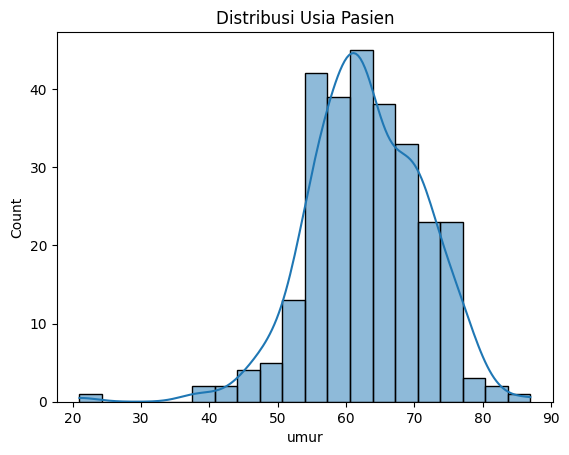

In [106]:
# Histogram usia
sns.histplot(df["umur"], bins=20, kde=True)
plt.title("Distribusi Usia Pasien")
plt.show()


In [104]:
# pie chart
age_bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]  # Adjust as needed
age_labels = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89']

age_groups = pd.cut(df['umur'], bins=age_bins, labels=age_labels, right=False)  # right=False ensures that the upper bound is excluded
age_counts = age_groups.value_counts().sort_index()

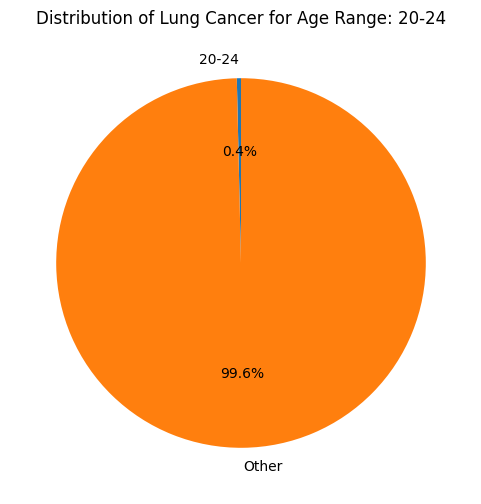

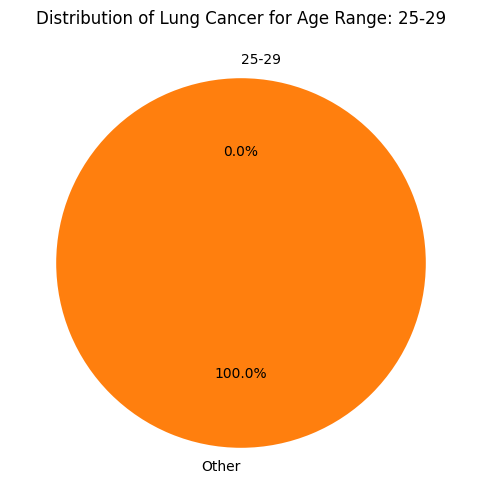

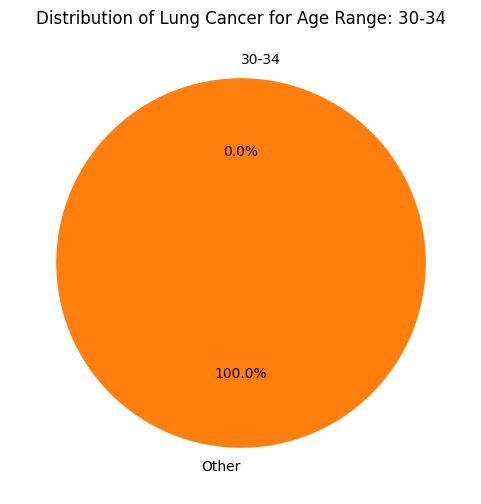

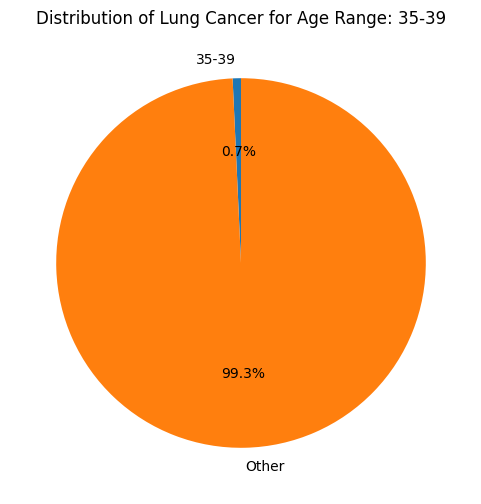

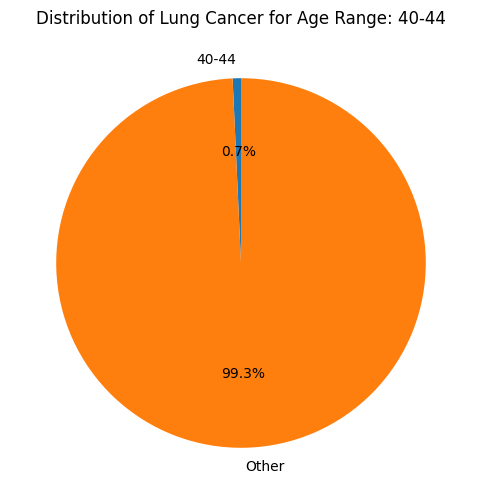

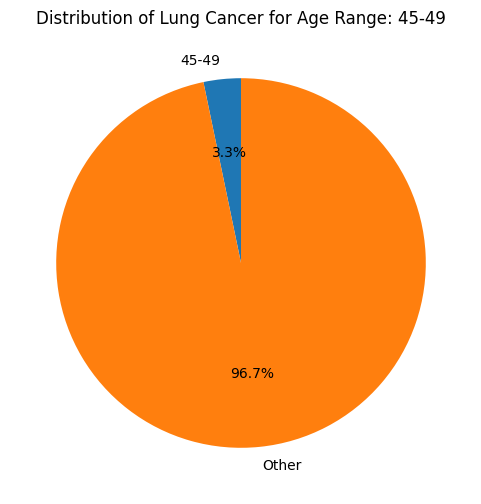

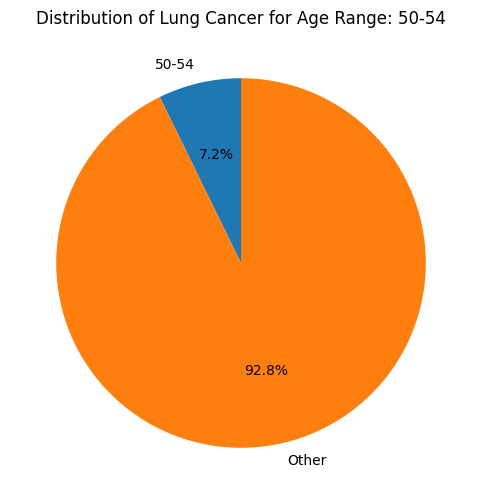

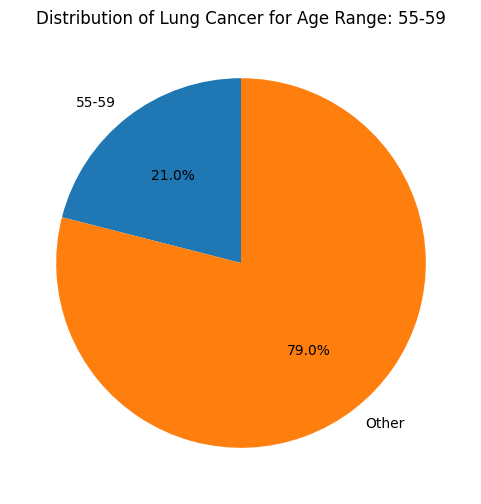

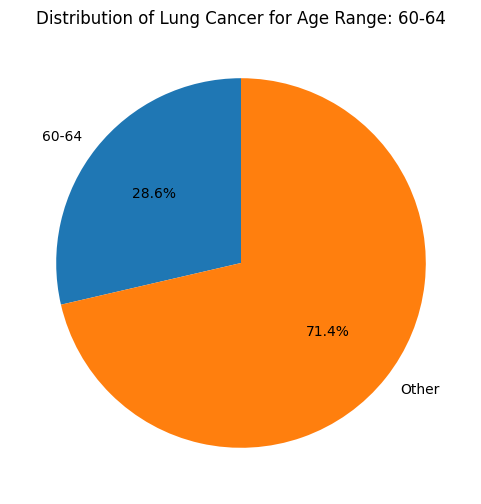

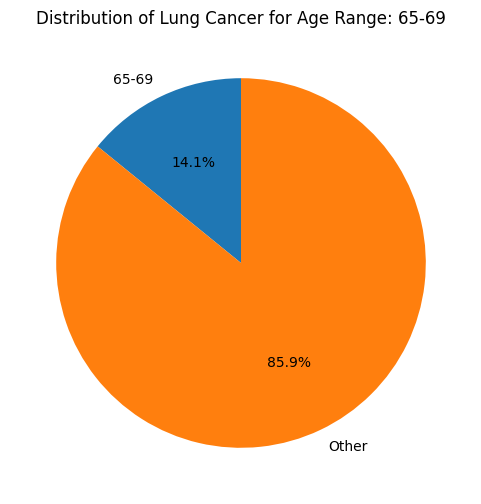

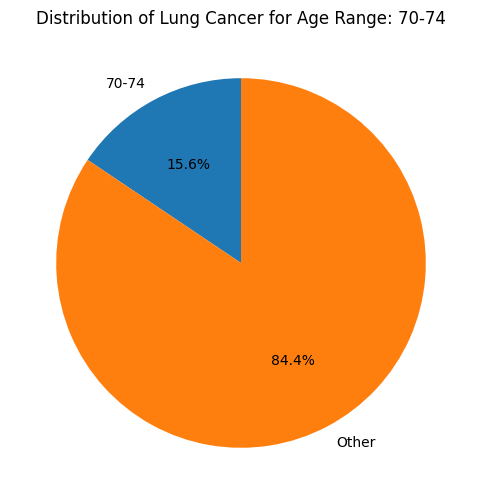

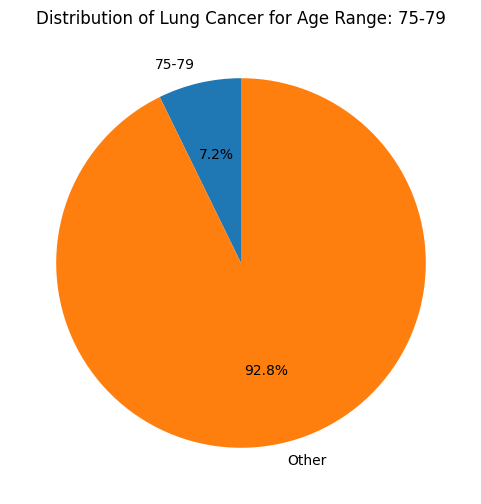

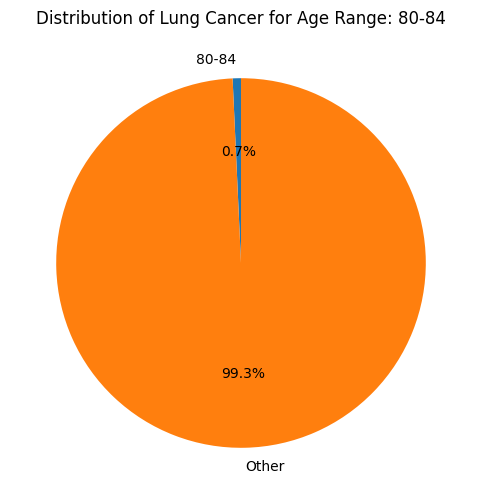

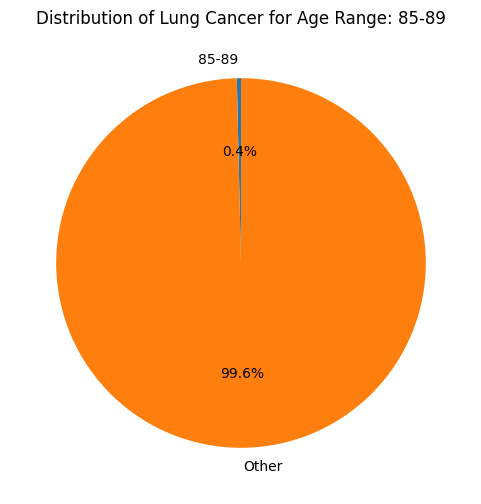

In [105]:
for age_range, count in age_counts.items():
    plt.figure(figsize=(6, 6))
    plt.pie([count, len(df) - count], labels=[age_range, 'Other'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of Lung Cancer for Age Range: {age_range}')
    plt.show()

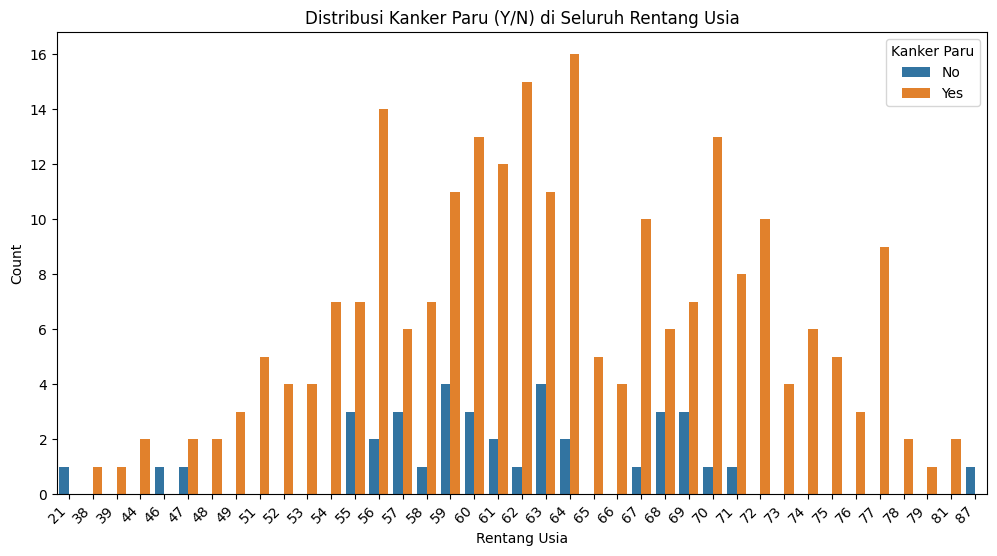

In [111]:
# binary barplot untuk seluruh rentang usia
df['age_group'] = pd.cut(df['umur'], bins=age_bins, labels=age_labels, right=False)

plt.figure(figsize=(12, 6))
sns.countplot(x='umur', hue='kanker_paru', data=df)
plt.title('Distribusi Kanker Paru (Y/N) di Seluruh Rentang Usia')
plt.xlabel('Rentang Usia')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Kanker Paru', labels=['No', 'Yes'])
plt.show()

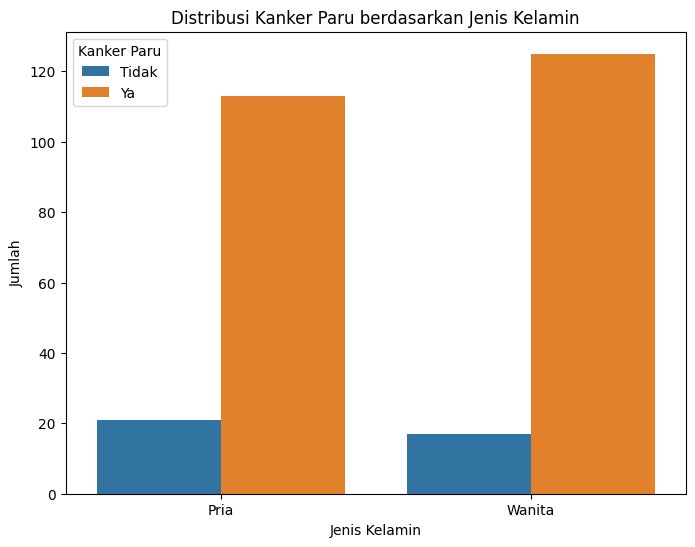

In [112]:
# binary barplot untuk jenis_kelamin dan kanker_paru
plt.figure(figsize=(8, 6))
sns.countplot(x='jenis_kelamin', hue='kanker_paru', data=df)
plt.title('Distribusi Kanker Paru berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin').
plt.ylabel('Jumlah')
plt.xticks(ticks=[0, 1], labels=['Pria', 'Wanita'])
plt.legend(title='Kanker Paru', labels=['Tidak', 'Ya'])
plt.show()

# Feature Selection

In [114]:
# chi-square test
categorical_features = ['jenis_kelamin', 'merokok', 'jari_kuning', 'kecemasan',
                         'tekanan_dari_teman', 'penyakit_kronis', 'kelelahan',
                         'alergi', 'mengi', 'konsumsi_alkohol', 'batuk',
                         'sesak_napas', 'kesulitan_menelan', 'sakit_dada']

for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(df[feature], df['kanker_paru'])

    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print(f"Chi-squared test for {feature}:")
    print(f"Chi-squared statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("-" * 20)

Chi-squared test for jenis_kelamin:
Chi-squared statistic: 0.5137930768381836
P-value: 0.4735014562057904
Degrees of freedom: 1
--------------------
Chi-squared test for merokok:
Chi-squared statistic: 0.1632829974094897
P-value: 0.6861517524363567
Degrees of freedom: 1
--------------------
Chi-squared test for jari_kuning:
Chi-squared statistic: 8.799189127946649
P-value: 0.003013644582751028
Degrees of freedom: 1
--------------------
Chi-squared test for kecemasan:
Chi-squared statistic: 4.941538508846909
P-value: 0.026218689238431014
Degrees of freedom: 1
--------------------
Chi-squared test for tekanan_dari_teman:
Chi-squared statistic: 9.402208158805317
P-value: 0.0021672427038890037
Degrees of freedom: 1
--------------------
Chi-squared test for penyakit_kronis:
Chi-squared statistic: 4.894412669373968
P-value: 0.026943736855531426
Degrees of freedom: 1
--------------------
Chi-squared test for kelelahan:
Chi-squared statistic: 6.123763697357368
P-value: 0.013337652970972067
Deg

In [116]:
categorical_features = ['jenis_kelamin', 'merokok', 'jari_kuning', 'kecemasan',
                         'tekanan_dari_teman', 'penyakit_kronis', 'kelelahan',
                         'alergi', 'mengi', 'konsumsi_alkohol', 'batuk',
                         'sesak_napas', 'kesulitan_menelan', 'sakit_dada']

highest_chi2 = 0
highest_feature = ''

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['kanker_paru'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if chi2 > highest_chi2:
        highest_chi2 = chi2
        highest_feature = feature

print(f"Fitur dengan statistik Chi-kuadrat tertinggi: {highest_feature}")
print(f"Statistik Chi-kuadrat tertinggi: {highest_chi2}")

Fitur dengan statistik Chi-kuadrat tertinggi: alergi
Statistik Chi-kuadrat tertinggi: 28.79297034952009


# Modelling

In [118]:
#confusion matrix
features = ['jenis_kelamin', 'merokok', 'jari_kuning', 'kecemasan', 'tekanan_dari_teman', 'penyakit_kronis', 'kelelahan', 'alergi', 'mengi', 'konsumsi_alkohol', 'batuk', 'sesak_napas', 'kesulitan_menelan', 'sakit_dada']
X = df[features]
y = df['kanker_paru']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9107142857142857
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.90      1.00      0.95        44

    accuracy                           0.91        56
   macro avg       0.95      0.79      0.84        56
weighted avg       0.92      0.91      0.90        56

[[ 7  5]
 [ 0 44]]


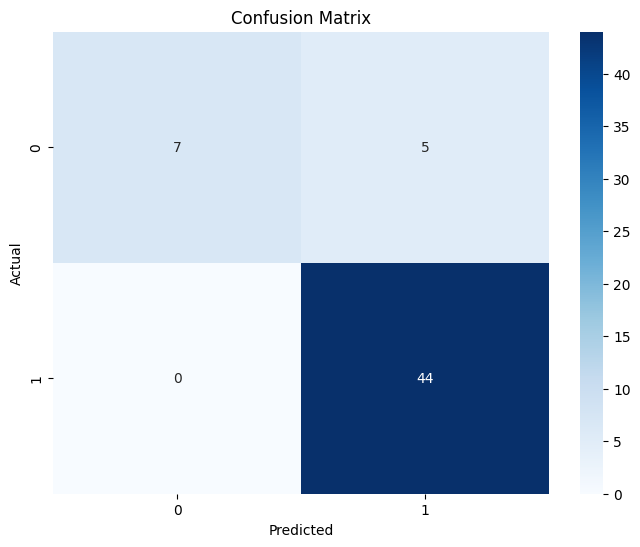

In [123]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()